**to do**  
* Nr_jobs for awesome cosine top

In [5]:
import json

# Needed to load in custom package from upper dir
# Not needed if you pip installed the package
import sys
sys.path.insert(1, '../')

# Custom packages
from polyfuzz.models import EditDistance, TFIDF, Embeddings, BaseMatcher
# from polyfuzz.metrics import precision_recall_curve
# from polyfuzz import PolyFuzz
import polyfuzz as pf
# Reload packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open("../data/company_names.json") as outfile:
    company_names = json.load(outfile)

with open("../data/movie_titles.json") as outfile:
    movie_titles = json.load(outfile)

In [3]:
from flair.embeddings import FlairEmbeddings, TransformerWordEmbeddings, TransformerDocumentEmbeddings
bert_embedding = TransformerWordEmbeddings('bert-base-multilingual-cased')

In [14]:
from rapidfuzz import fuzz
import numpy as np
import pandas as pd


class MyModel(BaseMatcher):
    def match(self, from_list, to_list):
        # Calculate distances
        matches = [[fuzz.ratio(from_string, to_string) / 100 for to_string in to_list] for from_string in from_list]
        
        # Get best matches
        mappings = [to_list[index] for index in np.argmax(matches, axis=1)]
        scores = np.max(matches, axis=1)
        
        # Prepare dataframe
        matches = pd.DataFrame({'From': from_list,'To': mappings, 'Similarity': scores})
        return matches

models = [
          TFIDF(n_gram_range=(3, 3), min_similarity=0, model_id="TF-IDF-Sklearn"),
          TFIDF(n_gram_range=(3, 6), min_similarity=0),
          EditDistance(n_jobs=-1),
          Embeddings([bert_embedding], min_similarity=0),
          MyModel()
         ]


# pm = PolyFuzz(models, movie_titles["Netflix"], movie_titles["Netflix"]).match()
# model = pf.PolyFuzz(models, movie_titles["Netflix"][:1000], movie_titles["IMDB"][:1000]).match()
# pm = PolyMatch(models, company_names[:5_000], company_names[:5_000]).match()
model = pf.PolyFuzz(models).match(from_list = ["string_one", "string_two"],
                                  to_list = ["string_three", "string_four"])

# pm = PolyFuzz("TF-IDF", movie_titles["Netflix"], movie_titles["Netflix"]).match()
# pm = PolyMatch("EditDistance", movie_titles["Netflix"], movie_titles["Netflix"]).match()
# pm = PolyMatch("Embeddings", movie_titles["Netflix"], movie_titles["Netflix"]).match()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.78it/s]


C:\Users\Maarten\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Maarten\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\programdata\miniconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\programdata\miniconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


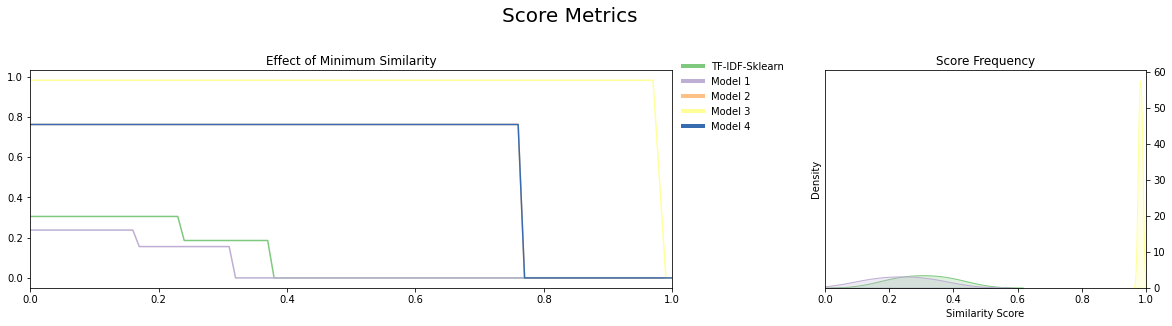

In [15]:
model.visualize_precision_recall()

In [19]:
min_precision, recall, _ = precision_recall_curve(pm.matches["Model 1"])

In [26]:
pm.group(minimum_similarity=0.8); 
df = pm.matches["Model 1"]

In [27]:
pm.get_all_model_ids()

['TF-IDF-Sklearn', 'Model 1', 'Model 2', 'Model 3', 'Model 4']

In [28]:
pm.matches["Model 4"]

,From,To,Similarity,Group
0,Norm of the North: King Sized Adventure,Norm of the North: King Sized Adventure,1.0,Norm of the North: King Sized Adventure
1,Jandino: Whatever it Takes,Jandino: Whatever it Takes,1.0,Jandino: Whatever it Takes
2,Transformers Prime,Transformers Prime,1.0,Transformer
3,Transformers: Robots in Disguise,Transformers: Robots in Disguise,1.0,Transformers: Robots in Disguise
4,#realityhigh,#realityhigh,1.0,#realityhigh
...,...,...,...,...
6167,Kikoriki,Kikoriki,1.0,Kikoriki
6168,Red vs. Blue,Red vs. Blue,1.0,Red vs. Blue
6169,Maron,Maron,1.0,Maron
6170,A Young Doctor's Notebook and Other Stories,A Young Doctor's Notebook and Other Stories,1.0,A Young Doctor's Notebook and Other Stories


# Edit distance

In [3]:
ed = EditDistance(n_jobs=-1, score_cutoff=0.5)
result = ed.match(movie_titles["Netflix"][:1000], movie_titles["IMDB"][:1000])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.91it/s]


In [4]:
result.head()

,From,To,Similarity
0,Norm of the North: King Sized Adventure,The Bargain,0.855
1,Jandino: Whatever it Takes,It's a Great Life,0.855
2,Transformers Prime,The Informer,0.600
3,Transformers: Robots in Disguise,Traffic in Souls,0.855
4,#realityhigh,It,0.900


# TF-IDF

In [24]:
model = TFIDF(n_gram_range=(3, 3), min_similarity=0.3)
# matches = tfidf.match(movie_titles["Netflix"], movie_titles["IMDB"][:1000])
matches = model.match(["string_one", "string_two"],
                      ["string_three", "string_four"])

In [26]:
matches.head()

,From,To,Similarity
0,string_one,None,0.000000
1,string_two,string_three,0.371644


# Embeddings

In [27]:
model = Embeddings(min_similarity=0.0)
matches = model.match(["string_one", "string_two"],
                      ["string_three", "string_four"])

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.62it/s]


In [23]:
from flair.embeddings import FlairEmbeddings, TransformerWordEmbeddings, TransformerDocumentEmbeddings
bert_embedding = TransformerWordEmbeddings('bert-base-multilingual-cased')

In [24]:
model = Embeddings([bert_embedding], min_similarity=0.0)
matches = model.match(["string_one", "string_two"],
                      ["string_three", "string_four"])